In [1]:
import torch
from torchvision.models.detection import ssd300_vgg16
from torch.utils.data import DataLoader, Subset
from pathlib import Path
import cv2
from torchvision import transforms
from tqdm import tqdm
import os
import numpy as np
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, log_loss

In [2]:
class MURADataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.label_dir = Path(label_dir)
        self.images = sorted(list(self.img_dir.glob("*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label_path = self.label_dir / (img_path.stem + ".txt")
        
        img = cv2.imread(str(img_path))
        if img is None:
            return None
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        try:
            with open(label_path, "r") as f:
                line = f.readline().strip().split()
                if not line:
                    return None
                class_id, x, y, w, h = map(float, line)
                x_min = (x - w/2) * 300
                y_min = (y - h/2) * 300
                x_max = (x + w/2) * 300
                y_max = (y + h/2) * 300
                if x_max <= x_min or y_max <= y_min:
                    return None
                target = {
                    "boxes": torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32),
                    "labels": torch.tensor([int(class_id)], dtype=torch.int64)
                }
        except Exception:
            return None

        if self.transform:
            img = self.transform(img)
        
        return img, target

In [3]:
# Define the device (GPU required)
device = torch.device("cuda")
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. This code requires a GPU.")
print(f"Using device: {device}")

# Define the transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training Dataset
train_dataset = MURADataset(
    "D:/Sem 6 project/MURA_YOLO/train/images",
    "D:/Sem 6 project/MURA_YOLO/train/labels",
    transform=transform
)

# Pre-filter training dataset
filtered_indices = []
for idx in range(len(train_dataset)):
    try:
        item = train_dataset[idx]
        if item is not None:
            filtered_indices.append(idx)
    except Exception:
        pass

train_dataset = Subset(train_dataset, filtered_indices)

# Validation Dataset
valid_dataset = MURADataset(
    "D:/Sem 6 project/MURA_YOLO/valid/images",
    "D:/Sem 6 project/MURA_YOLO/valid/labels",
    transform=transform
)

# Pre-filter validation dataset
filtered_indices = []
for idx in range(len(valid_dataset)):
    try:
        item = valid_dataset[idx]
        if item is not None:
            filtered_indices.append(idx)
    except Exception:
        pass

valid_dataset = Subset(valid_dataset, filtered_indices)

# Custom collate function
def custom_collate(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return [], []
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

# Data Loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    collate_fn=custom_collate,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    collate_fn=custom_collate,
    pin_memory=True
)

Using device: cuda


In [4]:
# Initialize SSD model with VGG backbone
model = ssd300_vgg16(num_classes=15, weights=None)

# Move the model to GPU
model = model.to(device)

In [12]:
from pathlib import Path
import torch

checkpoint_dir = Path("D:/Sem 6 project/checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

start_epoch = 0
latest_checkpoint_path = checkpoint_dir / "ssd_vgg_mura_epoch11.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if latest_checkpoint_path.exists():
    try:
        checkpoint = torch.load(latest_checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming from epoch {start_epoch}")
    except RuntimeError as e:
        print(f"Error loading checkpoint: {e}")
        print("Starting from scratch due to corrupted checkpoint")
else:
    print("No checkpoint found, starting from scratch")

Resuming from epoch 11


In [13]:
num_epochs = 25

# Define the optimizer (place this before the training loop)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust lr as needed

for epoch in range(start_epoch, num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    model.train()
    total_loss = 0
    total_accuracy = 0
    batch_count = 0
    
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for images, targets in train_loader:
            if not images:
                pbar.update(1)
                continue
            
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass for training (compute loss)
            loss_dict = model(images, targets)
            losses = sum(loss_dict.values())
            
            # Backward pass with optimizer
            optimizer.zero_grad()  # Clear previous gradients
            losses.backward()      # Compute gradients
            optimizer.step()       # Update weights
            
            # Compute accuracy by switching to eval mode temporarily
            model.eval()
            with torch.no_grad():
                preds = model(images)
            model.train()
            
            batch_accuracy = 0
            for pred, target in zip(preds, targets):
                pred_labels = pred['labels']
                pred_scores = pred['scores']
                gt_labels = target['labels']
                if len(pred_labels) > 0:
                    max_score_idx = torch.argmax(pred_scores)
                    pred_label = pred_labels[max_score_idx].item()
                    correct = 1.0 if pred_label == gt_labels[0].item() else 0.0
                    batch_accuracy += correct
            batch_accuracy /= len(targets) if len(targets) > 0 else 1
            
            # GPU memory usage
            current_mem = torch.cuda.memory_allocated(device) / 1e9
            total_mem = torch.cuda.get_device_properties(device).total_memory / 1e9
            mem_str = f"{current_mem:.2f}/{total_mem:.2f}GB"
            
            total_loss += losses.item()
            total_accuracy += batch_accuracy
            batch_count += 1
            
            pbar.set_postfix({
                'loss': f"{losses.item():.4f}",
                'acc': f"{batch_accuracy:.4f}",
                'mem': mem_str
            })
            pbar.update(1)
    
    avg_loss = total_loss / batch_count if batch_count > 0 else 0
    avg_accuracy = total_accuracy / batch_count if batch_count > 0 else 0
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")
    
    # Save checkpoint
    checkpoint_path = checkpoint_dir / f"ssd_vgg_mura_epoch{epoch+1}.pt"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state too
    }, checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")
    
    # Save latest checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state too
    }, latest_checkpoint_path)
    print(f"Saved latest checkpoint: {latest_checkpoint_path}")


Epoch 12/25


Epoch 12/25: 100%|████████████████████████| 576/576 [25:59<00:00,  2.71s/it, loss=0.9402, acc=0.6667, mem=0.74/12.88GB]


Epoch 12/25, Avg Loss: 0.7337, Avg Accuracy: 0.6279
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch12.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 13/25


Epoch 13/25: 100%|████████████████████████| 576/576 [21:26<00:00,  2.23s/it, loss=0.6051, acc=1.0000, mem=0.74/12.88GB]


Epoch 13/25, Avg Loss: 0.7122, Avg Accuracy: 0.6360
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch13.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 14/25


Epoch 14/25: 100%|████████████████████████| 576/576 [21:46<00:00,  2.27s/it, loss=1.0266, acc=0.6667, mem=0.74/12.88GB]


Epoch 14/25, Avg Loss: 0.7942, Avg Accuracy: 0.6225
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch14.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 15/25


Epoch 15/25: 100%|████████████████████████| 576/576 [24:48<00:00,  2.58s/it, loss=0.3645, acc=1.0000, mem=0.74/12.88GB]


Epoch 15/25, Avg Loss: 0.7206, Avg Accuracy: 0.6331
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch15.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 16/25


Epoch 16/25: 100%|████████████████████████| 576/576 [33:03<00:00,  3.44s/it, loss=0.4929, acc=0.8333, mem=0.74/12.88GB]


Epoch 16/25, Avg Loss: 0.6605, Avg Accuracy: 0.6548
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch16.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 17/25


Epoch 17/25: 100%|████████████████████████| 576/576 [28:02<00:00,  2.92s/it, loss=1.3821, acc=0.8333, mem=0.74/12.88GB]


Epoch 17/25, Avg Loss: 0.6393, Avg Accuracy: 0.6692
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch17.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 18/25


Epoch 18/25: 100%|████████████████████████| 576/576 [23:33<00:00,  2.45s/it, loss=1.7109, acc=0.8333, mem=0.74/12.88GB]


Epoch 18/25, Avg Loss: 0.6434, Avg Accuracy: 0.6698
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch18.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 19/25


Epoch 19/25: 100%|████████████████████████| 576/576 [23:23<00:00,  2.44s/it, loss=0.4366, acc=1.0000, mem=0.74/12.88GB]


Epoch 19/25, Avg Loss: 0.6054, Avg Accuracy: 0.6857
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch19.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 20/25


Epoch 20/25: 100%|████████████████████████| 576/576 [23:26<00:00,  2.44s/it, loss=0.6375, acc=0.8333, mem=0.74/12.88GB]


Epoch 20/25, Avg Loss: 0.5748, Avg Accuracy: 0.6981
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch20.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 21/25


Epoch 21/25: 100%|████████████████████████| 576/576 [23:27<00:00,  2.44s/it, loss=0.6982, acc=0.8333, mem=0.74/12.88GB]


Epoch 21/25, Avg Loss: 0.5506, Avg Accuracy: 0.7078
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch21.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 22/25


Epoch 22/25: 100%|████████████████████████| 576/576 [23:26<00:00,  2.44s/it, loss=0.5569, acc=1.0000, mem=0.74/12.88GB]


Epoch 22/25, Avg Loss: 0.5319, Avg Accuracy: 0.7224
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch22.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 23/25


Epoch 23/25: 100%|████████████████████████| 576/576 [23:27<00:00,  2.44s/it, loss=0.7035, acc=0.8333, mem=0.74/12.88GB]


Epoch 23/25, Avg Loss: 0.5439, Avg Accuracy: 0.7192
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch23.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 24/25


Epoch 24/25: 100%|████████████████████████| 576/576 [22:29<00:00,  2.34s/it, loss=0.3701, acc=1.0000, mem=0.74/12.88GB]


Epoch 24/25, Avg Loss: 0.5249, Avg Accuracy: 0.7263
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch24.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt

Epoch 25/25


Epoch 25/25: 100%|████████████████████████| 576/576 [28:56<00:00,  3.01s/it, loss=0.3126, acc=0.8333, mem=0.74/12.88GB]


Epoch 25/25, Avg Loss: 0.4793, Avg Accuracy: 0.7472
Saved checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch25.pt
Saved latest checkpoint: D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt


In [15]:
# Load the latest checkpoint before evaluation
if latest_checkpoint_path.exists():
    checkpoint = torch.load(latest_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from {latest_checkpoint_path} for evaluation")
else:
    print("No checkpoint found for evaluation. Using current model state.")

def evaluate(model, data_loader, device, desc="Evaluating"):
    model.eval()
    total_accuracy = 0
    batch_count = 0
    all_preds = []
    all_targets = []
    all_scores = []
    total_log_loss = 0

    with torch.no_grad():
        with tqdm(total=len(data_loader), desc=desc) as pbar:
            for batch_idx, (images, targets) in enumerate(data_loader):
                if not images or len(images) != len(targets):
                    pbar.update(1)
                    continue

                try:
                    images = [img.to(device) for img in images]
                    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                    preds = model(images)

                    batch_accuracy = 0
                    batch_preds = []
                    batch_targets = []
                    batch_scores = []
                    for pred, target in zip(preds, targets):
                        pred_labels = pred['labels']
                        pred_scores = pred['scores']
                        gt_labels = target['labels']
                        if len(pred_labels) > 0:
                            max_score_idx = torch.argmax(pred_scores)
                            pred_label = pred_labels[max_score_idx].item()
                            pred_score = pred_scores[max_score_idx].item()
                            correct = 1.0 if (pred_label == gt_labels[0].item()) else 0.0
                            batch_accuracy += correct
                        else:
                            pred_label = 0
                            pred_score = 0.0
                            batch_accuracy += 0
                        batch_preds.append(pred_label)
                        batch_targets.append(gt_labels[0].item())
                        batch_scores.append(pred_score)

                    batch_accuracy /= len(targets) if len(targets) > 0 else 1

                    binary_targets = [1 if t > 0 else 0 for t in batch_targets]
                    binary_probs = torch.sigmoid(torch.tensor(batch_scores, dtype=torch.float)).cpu().numpy()
                    binary_probs_2d = np.vstack([1 - binary_probs, binary_probs]).T
                    batch_log_loss = log_loss(binary_targets, binary_probs_2d, labels=[0, 1])
                    total_log_loss += batch_log_loss

                    all_preds.extend(batch_preds)
                    all_targets.extend(batch_targets)
                    all_scores.extend(batch_scores)

                    total_accuracy += batch_accuracy
                    batch_count += 1

                    pbar.set_postfix({'acc': f"{batch_accuracy:.4f}"})
                    pbar.update(1)
                except RuntimeError as e:
                    print(f"Evaluation error in batch {batch_idx+1}: {e}")
                    torch.cuda.empty_cache()

    avg_accuracy = total_accuracy / batch_count if batch_count > 0 else 0
    avg_log_loss = total_log_loss / batch_count if batch_count > 0 else 0

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_scores = np.array(all_scores)

    true_positives = np.sum((all_preds > 0) & (all_targets > 0))
    true_negatives = np.sum((all_preds == 0) & (all_targets == 0))
    false_positives = np.sum((all_preds > 0) & (all_targets == 0))
    false_negatives = np.sum((all_preds == 0) & (all_targets > 0))

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
    g_mean = np.sqrt(recall * specificity) if (recall * specificity) > 0 else 0

    binary_targets = (all_targets > 0).astype(int)
    binary_scores = np.array(all_scores)
    auc = roc_auc_score(binary_targets, binary_scores) if len(np.unique(binary_targets)) > 1 else 0

    mcc = matthews_corrcoef(all_targets, all_preds)
    kappa = cohen_kappa_score(all_targets, all_preds)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": avg_accuracy,
        "specificity": specificity,
        "g_mean": g_mean,
        "auc": auc,
        "mcc": mcc,
        "kappa": kappa,
        "log_loss": avg_log_loss
    }

# Evaluate on Training Set
print("\nEvaluating on Training Set:")
train_metrics = evaluate(model, train_loader, device, desc="Eval on Train")
print("Train Evaluation Metrics:")
print(f"1. Precision: {train_metrics['precision']:.4f}")
print(f"2. Recall: {train_metrics['recall']:.4f}")
print(f"3. F1 Score: {train_metrics['f1']:.4f}")
print(f"4. Accuracy: {train_metrics['accuracy']:.4f}")
print(f"5. Specificity: {train_metrics['specificity']:.4f}")
print(f"6. G-Mean: {train_metrics['g_mean']:.4f}")
print(f"7. AUC (ROC-AUC): {train_metrics['auc']:.4f}")
print(f"8. MCC: {train_metrics['mcc']:.4f}")
print(f"9. Cohen's Kappa: {train_metrics['kappa']:.4f}")
print(f"10. Log Loss: {train_metrics['log_loss']:.4f}")

# Evaluate on Validation Set
print("\nEvaluating on Validation Set:")
valid_metrics = evaluate(model, valid_loader, device, desc="Eval on Valid")
print("Validation Evaluation Metrics:")
print(f"1. Precision: {valid_metrics['precision']:.4f}")
print(f"2. Recall: {valid_metrics['recall']:.4f}")
print(f"3. F1 Score: {valid_metrics['f1']:.4f}")
print(f"4. Accuracy: {valid_metrics['accuracy']:.4f}")
print(f"5. Specificity: {valid_metrics['specificity']:.4f}")
print(f"6. G-Mean: {valid_metrics['g_mean']:.4f}")
print(f"7. AUC (ROC-AUC): {valid_metrics['auc']:.4f}")
print(f"8. MCC: {valid_metrics['mcc']:.4f}")
print(f"9. Cohen's Kappa: {valid_metrics['kappa']:.4f}")
print(f"10. Log Loss: {valid_metrics['log_loss']:.4f}")

C:\Users\HP\AppData\Local\Temp\ipykernel_10524\1606445259.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint_path, map_location=de

Loaded model from D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch11.pt for evaluation

Evaluating on Training Set:


Eval on Train: 100%|█████████████████████████████████████████████████████| 576/576 [17:57<00:00,  1.87s/it, acc=0.6667]


Train Evaluation Metrics:
1. Precision: 0.9205
2. Recall: 1.0000
3. F1 Score: 0.9586
4. Accuracy: 0.7349
5. Specificity: 0.0000
6. G-Mean: 0.0000
7. AUC (ROC-AUC): 0.2741
8. MCC: 0.7111
9. Cohen's Kappa: 0.7065
10. Log Loss: 0.4402

Evaluating on Validation Set:


Eval on Valid: 100%|███████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.52s/it, acc=0.5902]

Validation Evaluation Metrics:
1. Precision: 0.9265
2. Recall: 1.0000
3. F1 Score: 0.9618
4. Accuracy: 0.5618
5. Specificity: 0.0000
6. G-Mean: 0.0000
7. AUC (ROC-AUC): 0.3059
8. MCC: 0.5275
9. Cohen's Kappa: 0.5240
10. Log Loss: 0.4385


In [14]:
import os
print("Current PID:", os.getpid())


Current PID: 10524


Using device: cuda
Loaded checkpoint from D:\Sem 6 project\checkpoints\ssd_vgg_mura_epoch25.pt


Evaluating on validation set: 100%|████████████████████████████████████████████████████| 50/50 [02:38<00:00,  3.17s/it]


Validation Results - Avg Loss: 1.0717, Avg Accuracy: 0.5618


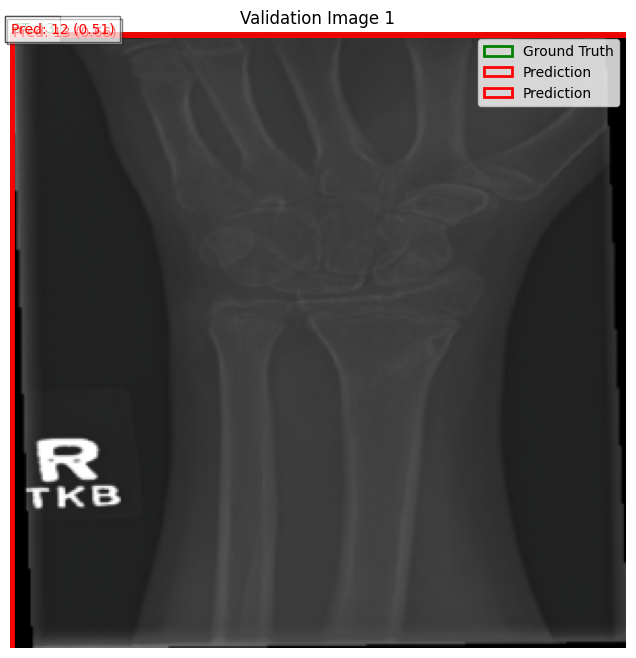

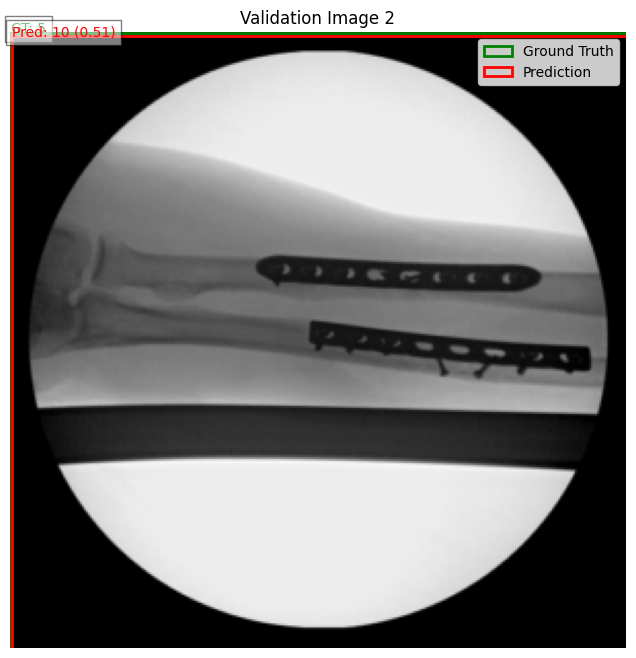

In [5]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import cv2
from pathlib import Path
from tqdm import tqdm
import numpy as np

# SSD model from torchvision
from torchvision.models.detection import ssd300_vgg16

# Define the MURADataset class directly
class MURADataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.label_dir = Path(label_dir)
        self.images = sorted(list(self.img_dir.glob("*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label_path = self.label_dir / (img_path.stem + ".txt")
        
        img = cv2.imread(str(img_path))
        if img is None:
            return None
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        try:
            with open(label_path, "r") as f:
                line = f.readline().strip().split()
                if not line:
                    return None
                class_id, x, y, w, h = map(float, line)
                x_min = (x - w/2) * 300
                y_min = (y - h/2) * 300
                x_max = (x + w/2) * 300
                y_max = (y + h/2) * 300
                if x_max <= x_min or y_max <= y_min:
                    return None
                target = {
                    "boxes": torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32),
                    "labels": torch.tensor([int(class_id)], dtype=torch.int64)
                }
        except Exception:
            return None

        if self.transform:
            img = self.transform(img)
        
        return img, target

# Define the device (GPU required)
device = torch.device("cuda")
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. This code requires a GPU.")
print(f"Using device: {device}")

# Define the transform (same as training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation Dataset
valid_dataset = MURADataset(
    img_dir="D:/Sem 6 project/MURA_YOLO/valid/images",
    label_dir="D:/Sem 6 project/MURA_YOLO/valid/labels",
    transform=transform
)

# Pre-filter validation dataset
filtered_indices = []
for idx in range(len(valid_dataset)):
    try:
        item = valid_dataset[idx]
        if item is not None:
            filtered_indices.append(idx)
    except Exception:
        pass

valid_dataset = Subset(valid_dataset, filtered_indices)

# Custom collate function
def custom_collate(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return [], []
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

# Data Loader for validation
valid_loader = DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    collate_fn=custom_collate,
    pin_memory=True
)

# Initialize SSD model with VGG backbone
model = ssd300_vgg16(num_classes=15, weights=None)  # num_classes=15 as per your training code
model = model.to(device)

# Load the checkpoint with weights_only=True to address the FutureWarning
checkpoint_path = Path("D:/Sem 6 project/checkpoints/ssd_vgg_mura_epoch25.pt")
if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)  # Set weights_only=True in future
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded checkpoint from {checkpoint_path}")
else:
    raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")

# Evaluation metrics
total_loss = 0.0
total_accuracy = 0.0
batch_count = 0

# Iterate over validation set
with torch.no_grad():
    # Temporarily switch to training mode for loss computation
    model.train()  # SSD requires training mode to compute losses with targets
    for images, targets in tqdm(valid_loader, desc="Evaluating on validation set"):
        if not images:
            continue
        
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass for evaluation (compute loss)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())  # Sum the loss values
        
        # Switch to eval mode for predictions
        model.eval()
        preds = model(images)  # Inference mode, no targets
        
        # Compute accuracy (same method as training)
        batch_accuracy = 0
        for pred, target in zip(preds, targets):
            pred_labels = pred['labels']
            pred_scores = pred['scores']
            gt_labels = target['labels']
            if len(pred_labels) > 0:
                max_score_idx = torch.argmax(pred_scores)
                pred_label = pred_labels[max_score_idx].item()
                correct = 1.0 if pred_label == gt_labels[0].item() else 0.0
                batch_accuracy += correct
        batch_accuracy /= len(targets) if len(targets) > 0 else 1
        
        total_loss += losses.item()
        total_accuracy += batch_accuracy
        batch_count += 1
        
        # Switch back to train mode for the next iteration
        model.train()

# Compute average loss and accuracy
avg_loss = total_loss / batch_count if batch_count > 0 else 0
avg_accuracy = total_accuracy / batch_count if batch_count > 0 else 0

print(f"Validation Results - Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")

# Optional: Visualize predictions on a few validation images
def visualize_predictions(images, preds, targets, num_images=2):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    for i in range(min(num_images, len(images))):
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        img = np.clip(img, 0, 1)
        
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(img)
        
        # Ground truth boxes
        gt_boxes = targets[i]['boxes'].cpu().numpy()
        gt_labels = targets[i]['labels'].cpu().numpy()
        for box, label in zip(gt_boxes, gt_labels):
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                   linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
            ax.add_patch(rect)
            ax.text(x_min, y_min, f"GT: {label}", color='g', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        
        # Predicted boxes
        pred_boxes = preds[i]['boxes'].cpu().numpy()
        pred_labels = preds[i]['labels'].cpu().numpy()
        pred_scores = preds[i]['scores'].cpu().numpy()
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            if score > 0.5:  # Threshold for visualization
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                       linewidth=2, edgecolor='r', facecolor='none', label='Prediction')
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"Pred: {label} ({score:.2f})", color='r', fontsize=10, 
                        bbox=dict(facecolor='white', alpha=0.5))
        
        plt.title(f"Validation Image {i+1}")
        plt.axis('off')
        plt.legend()
        plt.show()

# Switch to eval mode for visualization
model.eval()
with torch.no_grad():
    for images, targets in valid_loader:  # Get one batch for visualization
        if not images:
            continue
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        preds = model(images)
        visualize_predictions(images, preds, targets, num_images=2)
        break  # Only visualize one batch